In [1]:
import torchvision
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )
device = "cuda" if torch.cuda.is_available() else "cpu"

Everything taken and adapter from: https://www.youtube.com/watch?v=a4Yfz2FxXiY and https://colab.research.google.com/drive/1sjy9odlSSy0RBVgMTgP7s99NXsqglsUL?usp=sharing

In [2]:
def get_beta_schedule(timesteps, start=1e-5, end=2e-3):
    return torch.linspace(steps=timesteps, start=start, end=end)


def get_index_from_list(vals, t, x_shape):
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)


def forward_diffusion(x_0, t, device="cpu"):
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(
        device), noise.to(device)


# beta schedule
T = 300
betas = get_beta_schedule(timesteps=T)

alphas = 1 - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=0.1)
sqrt_recip_alphas = torch.sqrt(1 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [3]:
from torchvision import transforms
from torch.utils.data import DataLoader

BATCH_SIZE = 32
IMG_SIZE = 32
data_transforms = [
    torchvision.transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x * 2) - 1)
]
data_transform = transforms.Compose(data_transforms)
# Download training data from open datasets.
training_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=data_transform,
)

# Download test data from open datasets.
test_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=data_transform,
)
full_data = torch.utils.data.ConcatDataset([training_data, test_data])

dataloader = DataLoader(full_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)


100%|██████████| 26421880/26421880 [00:00<00:00, 115617198.36it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 7831154.01it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 60993314.90it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 22398627.59it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



<ipython-input-4-bc37fa47b7af>:23: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images + 1, int(idx / stepsize) + 1)


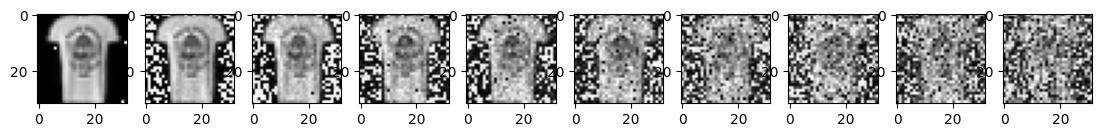

In [4]:
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),  # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8))
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    image = reverse_transforms(image)
    plt.imshow(image[0], cmap="gray")


image = next(iter(dataloader))[0]
plt.figure(figsize=(15, 15))
plt.axis('off')
num_images = 10
stepsize = int(T / num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images + 1, int(idx / stepsize) + 1)
    img, noise = forward_diffusion(image, t)
    show_tensor_image(img)

In [5]:
from torch import nn
import math

class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2 * in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()

    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(...,) + (None,) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """

    def __init__(self):
        super().__init__()
        image_channels = 1
        down_channels = (32, 64, 128, 256)
        up_channels = (256, 128, 64, 32)
        out_dim = 1
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )

        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i + 1], \
                                          time_emb_dim) \
                                    for i in range(len(down_channels) - 1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i + 1], \
                                        time_emb_dim, up=True) \
                                  for i in range(len(up_channels) - 1)])

        # Edit: Corrected a bug found by Jakub C (see YouTube comment)
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        return self.output(x)


model = SimpleUnet()
#print("Num params: ", sum(p.numel() for p in model.parameters()))
#model

In [6]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns
    the denoised image.
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
            x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

    if t == 0:
        # As pointed out by Luis Pereira (see YouTube comment)
        # The t's are offset from the t's in the paper
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise


@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 1, img_size, img_size), device=device)
    plt.figure(figsize=(15, 15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T / num_images)

    for i in range(0, T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        # Edit: This is to maintain the natural range of the distribution
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i / stepsize) + 1)
            show_tensor_image(img.detach().cpu())
    plt.show()#%%
import torchvision
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"


In [7]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

cuda
Epoch 0 | step 000 Loss: 0.8095165491104126 


<ipython-input-6-671d9f1703fe>:45: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, int(i / stepsize) + 1)


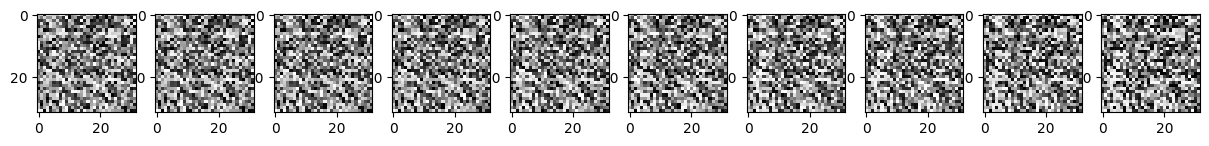

Epoch 0 | Loss: 0.23829880356788635
Epoch 1 | Loss: 0.20826202630996704
Epoch 2 | Loss: 0.19138100743293762
Epoch 3 | Loss: 0.2028036117553711
Epoch 4 | Loss: 0.2167498618364334
Epoch 5 | step 000 Loss: 0.20496302843093872 


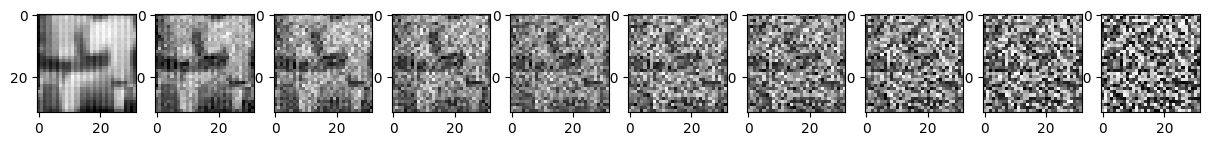

Epoch 5 | Loss: 0.2039019614458084
Epoch 6 | Loss: 0.22298339009284973
Epoch 7 | Loss: 0.23254819214344025
Epoch 8 | Loss: 0.18997976183891296
Epoch 9 | Loss: 0.19459575414657593
Epoch 10 | step 000 Loss: 0.20447582006454468 


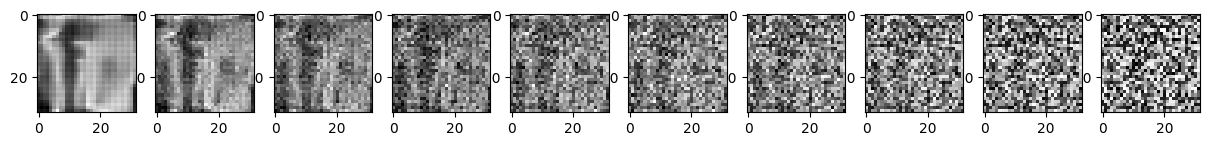

Epoch 10 | Loss: 0.17846053838729858
Epoch 11 | Loss: 0.17906247079372406
Epoch 12 | Loss: 0.16883337497711182
Epoch 13 | Loss: 0.19516390562057495
Epoch 14 | Loss: 0.17869096994400024
Epoch 15 | step 000 Loss: 0.18592798709869385 


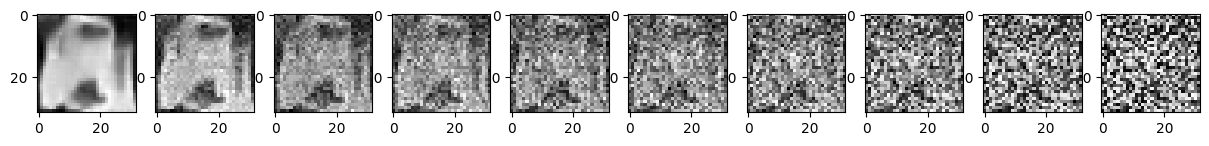

Epoch 15 | Loss: 0.18526354432106018
Epoch 16 | Loss: 0.19714891910552979
Epoch 17 | Loss: 0.19384518265724182
Epoch 18 | Loss: 0.1737663447856903
Epoch 19 | Loss: 0.18817003071308136
Epoch 20 | step 000 Loss: 0.17716851830482483 


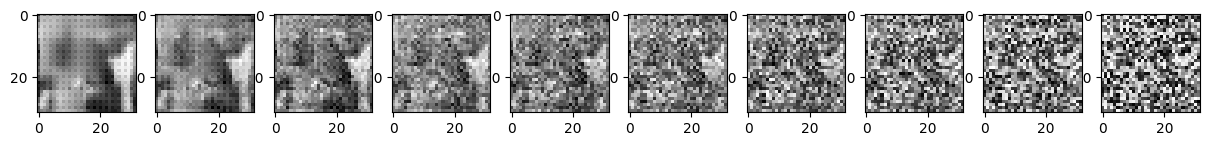

Epoch 20 | Loss: 0.1852152943611145
Epoch 21 | Loss: 0.15976950526237488
Epoch 22 | Loss: 0.17812985181808472
Epoch 23 | Loss: 0.16776666045188904
Epoch 24 | Loss: 0.1728748381137848
Epoch 25 | step 000 Loss: 0.1798541247844696 


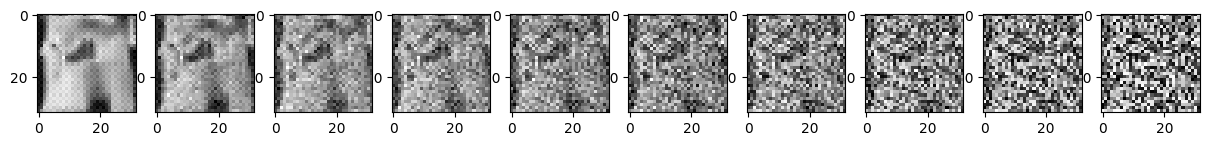

Epoch 25 | Loss: 0.1627802848815918
Epoch 26 | Loss: 0.17999932169914246
Epoch 27 | Loss: 0.15882720053195953
Epoch 28 | Loss: 0.16878080368041992
Epoch 29 | Loss: 0.17294414341449738
Epoch 30 | step 000 Loss: 0.18905338644981384 


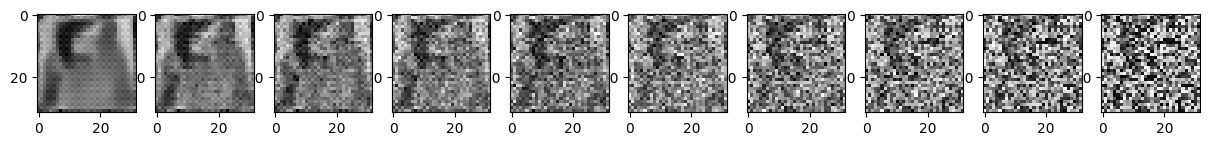

Epoch 30 | Loss: 0.2023448497056961
Epoch 31 | Loss: 0.17548228800296783
Epoch 32 | Loss: 0.18719083070755005
Epoch 33 | Loss: 0.1872812807559967
Epoch 34 | Loss: 0.17686036229133606
Epoch 35 | step 000 Loss: 0.14804863929748535 


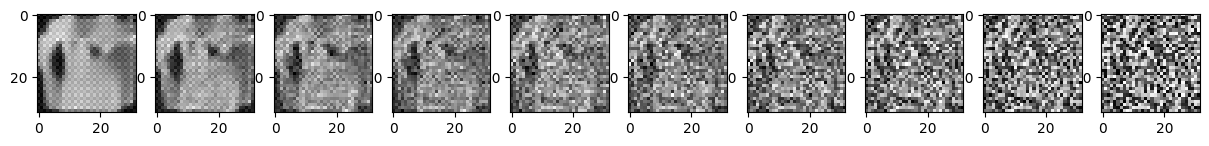

Epoch 35 | Loss: 0.17865169048309326
Epoch 36 | Loss: 0.2102259397506714
Epoch 37 | Loss: 0.20071405172348022
Epoch 38 | Loss: 0.1861913800239563
Epoch 39 | Loss: 0.18345704674720764
Epoch 40 | step 000 Loss: 0.18806453049182892 


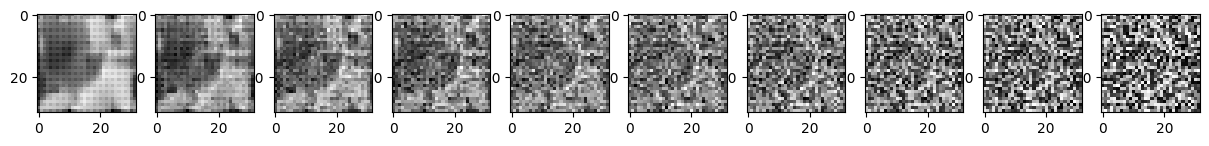

Epoch 40 | Loss: 0.17972391843795776
Epoch 41 | Loss: 0.1755032241344452
Epoch 42 | Loss: 0.16241687536239624
Epoch 43 | Loss: 0.203341543674469
Epoch 44 | Loss: 0.17963697016239166
Epoch 45 | step 000 Loss: 0.172899067401886 


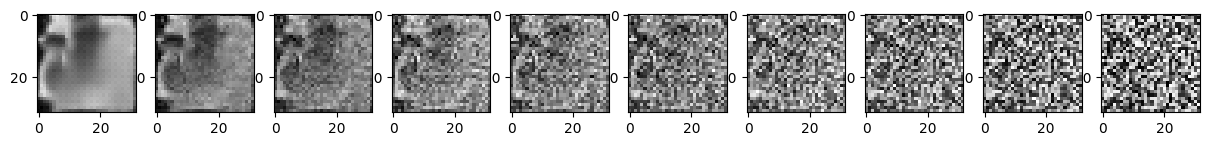

Epoch 45 | Loss: 0.160687655210495
Epoch 46 | Loss: 0.17893020808696747
Epoch 47 | Loss: 0.17881187796592712
Epoch 48 | Loss: 0.1712057888507843
Epoch 49 | Loss: 0.1758313626050949
Epoch 50 | step 000 Loss: 0.1886858344078064 


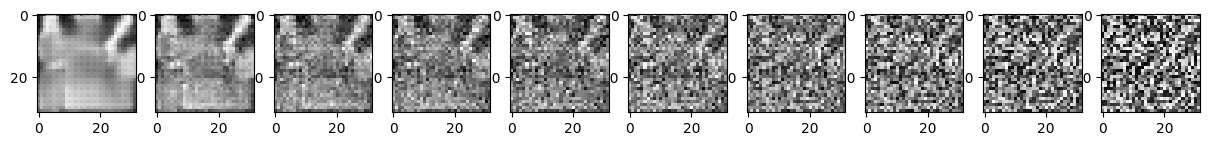

Epoch 50 | Loss: 0.18672023713588715
Epoch 51 | Loss: 0.17472237348556519
Epoch 52 | Loss: 0.18968501687049866
Epoch 53 | Loss: 0.15457013249397278
Epoch 54 | Loss: 0.16140858829021454
Epoch 55 | step 000 Loss: 0.15849915146827698 


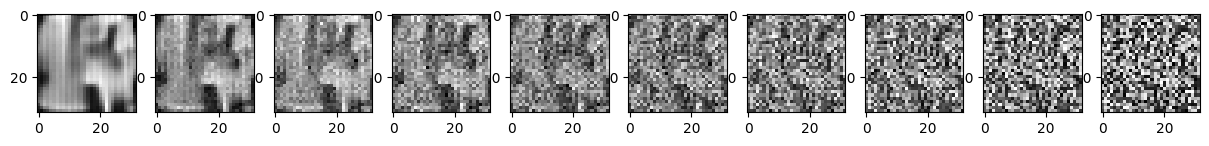

Epoch 55 | Loss: 0.17542120814323425
Epoch 56 | Loss: 0.19039621949195862
Epoch 57 | Loss: 0.17663246393203735
Epoch 58 | Loss: 0.1801406741142273
Epoch 59 | Loss: 0.17884184420108795
Epoch 60 | step 000 Loss: 0.16755373775959015 


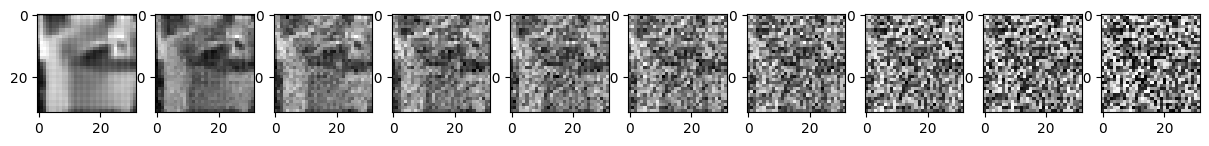

Epoch 60 | Loss: 0.17996519804000854
Epoch 61 | Loss: 0.19167792797088623
Epoch 62 | Loss: 0.1923828125
Epoch 63 | Loss: 0.1815982311964035
Epoch 64 | Loss: 0.19433093070983887
Epoch 65 | step 000 Loss: 0.16008493304252625 


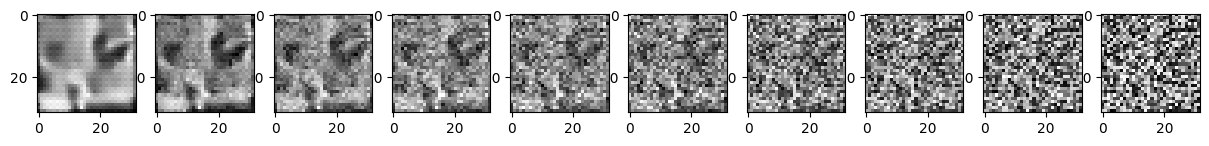

Epoch 65 | Loss: 0.1898052841424942
Epoch 66 | Loss: 0.19800245761871338
Epoch 67 | Loss: 0.16356351971626282
Epoch 68 | Loss: 0.16655202209949493
Epoch 69 | Loss: 0.17912441492080688
Epoch 70 | step 000 Loss: 0.1572512835264206 


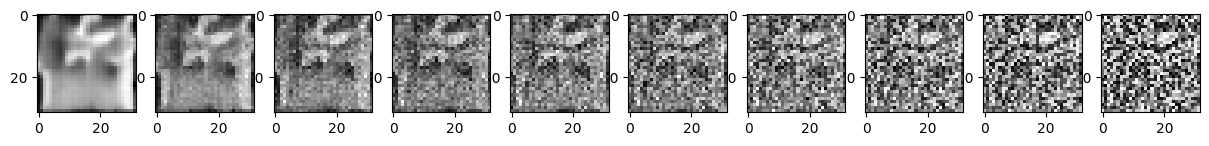

Epoch 70 | Loss: 0.1659516990184784
Epoch 71 | Loss: 0.18647688627243042
Epoch 72 | Loss: 0.17483915388584137
Epoch 73 | Loss: 0.16206759214401245
Epoch 74 | Loss: 0.1601272076368332
Epoch 75 | step 000 Loss: 0.1969088613986969 


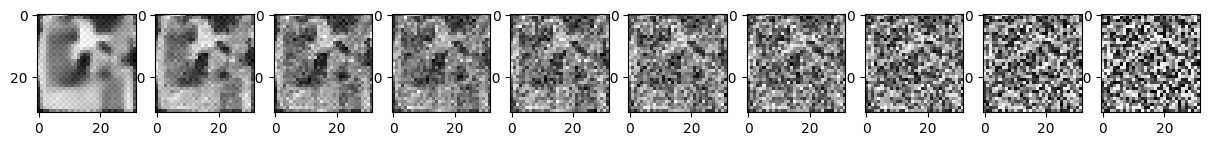

Epoch 75 | Loss: 0.14432907104492188
Epoch 76 | Loss: 0.1551748365163803
Epoch 77 | Loss: 0.17918944358825684
Epoch 78 | Loss: 0.1923951953649521
Epoch 79 | Loss: 0.17755945026874542
Epoch 80 | step 000 Loss: 0.19024240970611572 


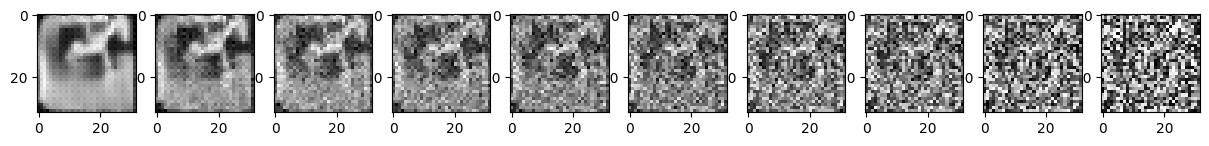

Epoch 80 | Loss: 0.18881076574325562
Epoch 81 | Loss: 0.17431025207042694
Epoch 82 | Loss: 0.17097339034080505
Epoch 83 | Loss: 0.17146994173526764
Epoch 84 | Loss: 0.19827519357204437
Epoch 85 | step 000 Loss: 0.18681767582893372 


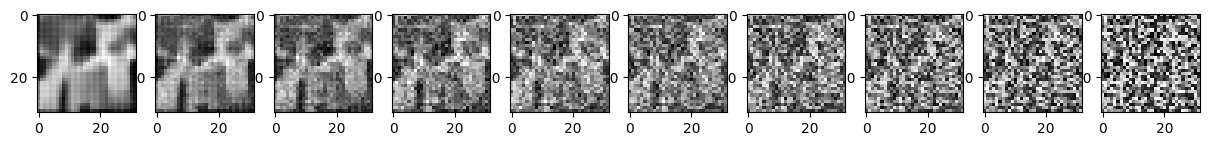

Epoch 85 | Loss: 0.20835351943969727
Epoch 86 | Loss: 0.19236133992671967
Epoch 87 | Loss: 0.15637297928333282
Epoch 88 | Loss: 0.1800651103258133
Epoch 89 | Loss: 0.18225909769535065
Epoch 90 | step 000 Loss: 0.18584904074668884 


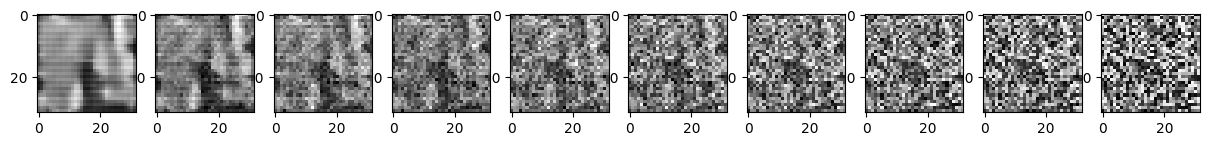

Epoch 90 | Loss: 0.15349939465522766
Epoch 91 | Loss: 0.1994251161813736
Epoch 92 | Loss: 0.17154709994792938
Epoch 93 | Loss: 0.16414105892181396
Epoch 94 | Loss: 0.21592256426811218
Epoch 95 | step 000 Loss: 0.1624382734298706 


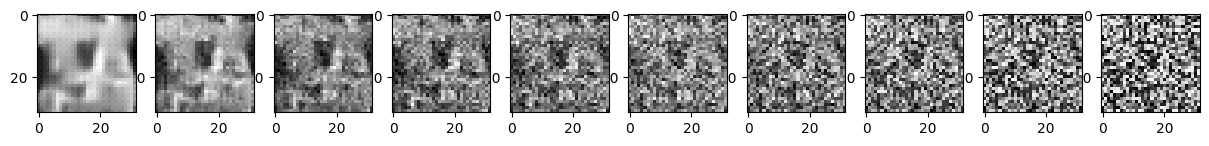

Epoch 95 | Loss: 0.1936594694852829
Epoch 96 | Loss: 0.16077756881713867
Epoch 97 | Loss: 0.19806653261184692
Epoch 98 | Loss: 0.17200110852718353
Epoch 99 | Loss: 0.1598348617553711


In [8]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model = SimpleUnet()
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 100 # Try more!

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
      loss = get_loss(model, batch[0], t)
      loss.backward()
      optimizer.step()

      if epoch % 5 == 0 and step == 0:
        print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
        sample_plot_image()
    print(f"Epoch {epoch} | Loss: {loss.item()}")

<ipython-input-6-671d9f1703fe>:45: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, int(i / stepsize) + 1)


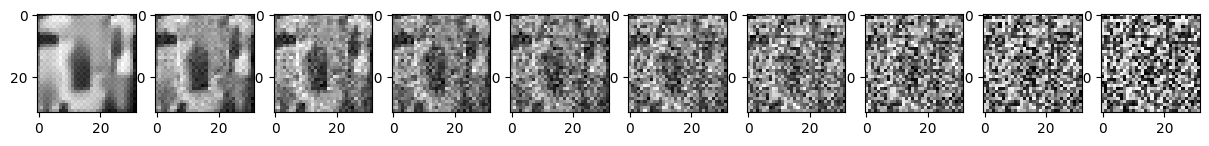

In [9]:
sample_plot_image()